In [ ]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import seaborn as sns
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
table = read_csv('/content/drive/MyDrive/Thesis/csvs/NNdata14_20.csv')
table.head()

Date  IDStation         NameStation  Ammonia  Arsenic  \
0  2014-01-01T00:00:00Z        681  Moggio Loc Penscei      0.0      NaN   
1  2014-01-02T00:00:00Z        681  Moggio Loc Penscei      0.0      NaN   
2  2014-01-03T00:00:00Z        681  Moggio Loc Penscei      0.0      1.1   
3  2014-01-04T00:00:00Z        681  Moggio Loc Penscei      0.0      NaN   
4  2014-01-05T00:00:00Z        681  Moggio Loc Penscei      0.0      NaN   

   Benzo_a_pyrene  Cadmium  Lead  Nikel  NO  ...  IDStation.2  \
0             0.1      NaN   NaN    NaN NaN  ...          111   
1             NaN      NaN   NaN    NaN NaN  ...          111   
2             NaN      0.0   1.1    4.2 NaN  ...          111   
3             0.1      NaN   NaN    NaN NaN  ...          111   
4             NaN      NaN   NaN    NaN NaN  ...          111   

               NameStation.1  Wind_speed  Wind_direction  Temperature  \
0  Cassina Valsassina Moggio    0.443554            99.0    -0.334965   
1  Cassina Valsassina Moggio    0.355915           105.0    -0.486111   
2  Cassina Valsassina Moggio    0.207631           120.0     2.220588   
3  Cassina Valsassina Moggio    1.024926           175.0     2.137063   
4  Cassina Valsassina Moggio    0.666721            94.0     2.416084   

   Relative_humidity  Global_radiation Wind_speed_max  Wind_direction_max  \
0          45.545455         58.097902       1.805594               143.0   
1          83.944444          0.000000       1.767361               153.0   
2          87.042254         30.514085       1.558451               152.0   
3          89.349650          0.202797       3.816783               164.0   
4          86.055944         10.951049       2.797203               136.0   

  Rainfall  
0      0.0  
1      7.8  
2      0.0  
3     35.8  
4     25.0  

[5 rows x 28 columns]

In [ ]:
#Moggio = table.loc[table.loc[:,"NameStation"]=="Moggio",:]
#PM 2.5 were removed
Moggio = table.loc[:,["Date","PM10","Ammonia","Wind_speed","Wind_direction","Temperature","Rainfall"]]
Moggio = Moggio.dropna(how="any")
Moggio = Moggio.reset_index()
Moggio = Moggio.iloc[:-365,:] # we train not using 2020, for now
Moggio.head()


index                  Date  PM10  Ammonia  Wind_speed  Wind_direction  \
0      0  2014-01-01T00:00:00Z   6.0      0.0    0.443554            99.0   
1      1  2014-01-02T00:00:00Z   6.0      0.0    0.355915           105.0   
2      2  2014-01-03T00:00:00Z  11.0      0.0    0.207631           120.0   
3      3  2014-01-04T00:00:00Z   6.0      0.0    1.024926           175.0   
4      4  2014-01-05T00:00:00Z   3.0      0.0    0.666721            94.0   

   Temperature  Rainfall  
0    -0.334965       0.0  
1    -0.486111       7.8  
2     2.220588       0.0  
3     2.137063      35.8  
4     2.416084      25.0

In [ ]:
# sns.lineplot(x='Date', y='PM25', data=Moggio)

##Convert series to supervised learning
### Activation function = tanh and logistic (s curve)

###Conversion Function

In [ ]:
from pandas import DataFrame
from pandas import concat
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

### Conversion of Moggio

In [ ]:
values = Moggio.iloc[:,2:].values
# ensure all data is float
values = values.astype('float32') #cast in float 32 bit per evitare problemi
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
n_days = 5 #Memoria della NN
reframed = series_to_supervised(scaled, n_days, 5) # info of the past 5 days to determine next (5) day
# drop columns we don't want to predict (we therefore keep Ammonia)
#reframed.drop(reframed.columns[[31,32,33,34,35]], axis=1, inplace=True)

reframed.head()

var1(t-5)  var2(t-5)  var3(t-5)  var4(t-5)  var5(t-5)  var6(t-5)  \
5   0.066667        0.0   0.163005   0.275000   0.286365   0.000000   
6   0.066667        0.0   0.130139   0.291667   0.282413   0.035199   
7   0.122222        0.0   0.074531   0.333333   0.353183   0.000000   
8   0.066667        0.0   0.381024   0.486111   0.350999   0.161552   
9   0.033333        0.0   0.246694   0.261111   0.358295   0.112816   

   var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  ...  var3(t+3)  var4(t+3)  \
5   0.066667        0.0   0.130139   0.291667  ...   0.063516   0.100000   
6   0.122222        0.0   0.074531   0.333333  ...   0.141334   0.738889   
7   0.066667        0.0   0.381024   0.486111  ...   0.068566   0.019444   
8   0.033333        0.0   0.246694   0.261111  ...   0.024003   0.188889   
9   0.022222        0.0   0.075776   0.222222  ...   0.122816   0.694444   

   var5(t+3)  var6(t+3)  var1(t+4)  var2(t+4)  var3(t+4)  var4(t+4)  \
5   0.392536   0.000000   0.133333        0.0   0.141334   0.738889   
6   0.409331   0.000000   0.122222        0.0   0.068566   0.019444   
7   0.387761   0.000000   0.066667        0.0   0.024003   0.188889   
8   0.425800   0.000000   0.177778        0.0   0.122816   0.694444   
9   0.335977   0.008123   0.066667        0.0   0.043570   0.833333   

   var5(t+4)  var6(t+4)  
5   0.409331   0.000000  
6   0.387761   0.000000  
7   0.425800   0.000000  
8   0.335977   0.008123  
9   0.294106   0.166967  

[5 rows x 60 columns]

In [ ]:
reframed.iloc[:,-6*5:]

var1(t)  var2(t)   var3(t)   var4(t)   var5(t)   var6(t)  var1(t+1)  \
5     0.022222      0.0  0.075776  0.222222  0.406390  0.000000   0.077778   
6     0.077778      0.0  0.034263  0.150000  0.397825  0.000000   0.044444   
7     0.044444      0.0  0.201140  0.269444  0.408315  0.000000   0.044444   
8     0.044444      0.0  0.063516  0.100000  0.392536  0.000000   0.133333   
9     0.133333      0.0  0.141334  0.738889  0.409331  0.000000   0.122222   
...        ...      ...       ...       ...       ...       ...        ...   
1727  0.044444      0.0  0.127052  0.413889  0.339844  0.021661   0.022222   
1728  0.022222      0.0  0.213303  0.497222  0.398437  0.169675   0.033333   
1729  0.033333      0.0  0.032820  0.261111  0.468415  0.013538   0.044444   
1730  0.044444      0.0  0.273680  0.488889  0.438365  0.011733   0.033333   
1731  0.033333      0.0  0.256569  0.547222  0.399272  0.193141   0.022222   

      var2(t+1)  var3(t+1)  var4(t+1)  ...  var3(t+3)  var4(t+3)  var5(t+3)  \
5           0.0   0.034263   0.150000  ...   0.063516   0.100000   0.392536   
6           0.0   0.201140   0.269444  ...   0.141334   0.738889   0.409331   
7           0.0   0.063516   0.100000  ...   0.068566   0.019444   0.387761   
8           0.0   0.141334   0.738889  ...   0.024003   0.188889   0.425800   
9           0.0   0.068566   0.019444  ...   0.122816   0.694444   0.335977   
...         ...        ...        ...  ...        ...        ...        ...   
1727        0.0   0.213303   0.497222  ...   0.273680   0.488889   0.438365   
1728        0.0   0.032820   0.261111  ...   0.256569   0.547222   0.399272   
1729        0.0   0.273680   0.488889  ...   1.000000   0.605556   0.440144   
1730        0.0   0.256569   0.547222  ...   0.441052   0.558333   0.478401   
1731        0.0   1.000000   0.605556  ...   0.068348   0.100000   0.532473   

      var6(t+3)  var1(t+4)  var2(t+4)  var3(t+4)  var4(t+4)  var5(t+4)  \
5      0.000000   0.133333        0.0   0.141334   0.738889   0.409331   
6      0.000000   0.122222        0.0   0.068566   0.019444   0.387761   
7      0.000000   0.066667        0.0   0.024003   0.188889   0.425800   
8      0.000000   0.177778        0.0   0.122816   0.694444   0.335977   
9      0.008123   0.066667        0.0   0.043570   0.833333   0.294106   
...         ...        ...        ...        ...        ...        ...   
1727   0.011733   0.033333        0.0   0.256569   0.547222   0.399272   
1728   0.193141   0.022222        0.0   1.000000   0.605556   0.440144   
1729   0.378159   0.000000        0.0   0.441052   0.558333   0.478401   
1730   0.073105   0.033333        0.0   0.068348   0.100000   0.532473   
1731   0.000000   0.055556        0.0   0.116845   0.472222   0.507234   

      var6(t+4)  
5      0.000000  
6      0.000000  
7      0.000000  
8      0.008123  
9      0.166967  
...         ...  
1727   0.193141  
1728   0.378159  
1729   0.073105  
1730   0.000000  
1731   0.000000  

[1727 rows x 30 columns]

In [ ]:
# split into train and test sets
values = reframed.values
n_features = 6 # number of variables, including the one to be predicted
n_train_days = 1312 # we train using only the first year
train = values[:n_train_days, :]
test = values[n_train_days:, :] # we test using all successive years 
# split into input and outputs
n_obs = n_days * n_features
train_X, train_y = train[:, :n_obs], train[:, -6*5:] #!!! -30 because we are predicting all 6 features for the the future 5 days (-6*5=30)
test_X, test_y = test[:, :n_obs], test[:, -6*5:]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
# reshape from 2D to 3D
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1312, 30) 1312 (1312, 30)
(1312, 5, 6) (1312, 30) (415, 5, 6) (415, 30)


# Modeling and training

Epoch 1/500
14/14 - 12s - loss: 0.2447 - val_loss: 0.2426 - 12s/epoch - 864ms/step
Epoch 2/500
14/14 - 0s - loss: 0.2029 - val_loss: 0.1861 - 283ms/epoch - 20ms/step
Epoch 3/500
14/14 - 0s - loss: 0.1636 - val_loss: 0.1493 - 280ms/epoch - 20ms/step
Epoch 4/500
14/14 - 0s - loss: 0.1322 - val_loss: 0.1277 - 280ms/epoch - 20ms/step
Epoch 5/500
14/14 - 0s - loss: 0.1175 - val_loss: 0.1197 - 281ms/epoch - 20ms/step
Epoch 6/500
14/14 - 0s - loss: 0.1108 - val_loss: 0.1161 - 331ms/epoch - 24ms/step
Epoch 7/500
14/14 - 0s - loss: 0.1073 - val_loss: 0.1126 - 315ms/epoch - 23ms/step
Epoch 8/500
14/14 - 0s - loss: 0.1046 - val_loss: 0.1100 - 299ms/epoch - 21ms/step
Epoch 9/500
14/14 - 0s - loss: 0.1032 - val_loss: 0.1082 - 324ms/epoch - 23ms/step
Epoch 10/500
14/14 - 0s - loss: 0.1032 - val_loss: 0.1074 - 278ms/epoch - 20ms/step
Epoch 11/500
14/14 - 0s - loss: 0.1040 - val_loss: 0.1062 - 278ms/epoch - 20ms/step
Epoch 12/500
14/14 - 0s - loss: 0.1038 - val_loss: 0.1063 - 278ms/epoch - 20ms/step
E

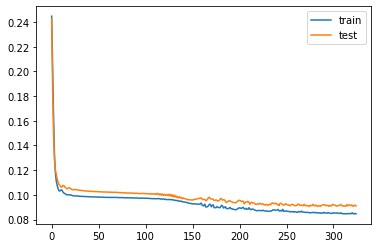

In [ ]:
# design the neural network
model = Sequential()
model.add(LSTM(30, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(30, return_sequences=True))
model.add(LSTM(30, return_sequences=True))
model.add(LSTM(30, return_sequences=True))
model.add(LSTM(30, return_sequences=False))
model.add(Dense(6*5)) # it outputs all 6 features, once for each of the 5 day included in the prediction 
model.compile(loss='mae', optimizer='adam')
# fit network
early_stopping = EarlyStopping(patience=50, restore_best_weights = True)
history = model.fit(train_X, train_y, epochs=500, batch_size=100, validation_data=(test_X, test_y), verbose=2, shuffle=False, callbacks=early_stopping)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

## Predictions of the year 2019

#### Prediciton plots

prediction with 2020

In [ ]:
#Moggio = table.loc[table.loc[:,"NameStation"]=="Moggio",:]
#PM 2.5 were removed
Moggio = table.loc[:,["Date","PM10","Ammonia","Wind_speed","Wind_direction","Temperature","Rainfall"]]
Moggio = Moggio.dropna(how="any")
Moggio = Moggio.reset_index()
Moggio = Moggio.iloc[:,:] # this is the differrence!!!! we keep the 2020 data 
Moggio.head()
values = Moggio.iloc[:,2:].values

# ensure all data is float
values = values.astype('float32') #cast in float 32 bit per evitare problemi
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
n_days = 5 #Memoria della NN
reframed = series_to_supervised(scaled, n_days, 5) # info of the past 5 days to determine next (5) day
# drop columns we don't want to predict (we therefore keep Ammonia)
#reframed.drop(reframed.columns[[31,32,33,34,35]], axis=1, inplace=True)

# split into train and test sets
values = reframed.values
n_features = 6 # number of variables, including the one to be predicted
n_train_days = 1312 # we train using only the first year
train = values[:n_train_days, :]
test = values[n_train_days:, :] # we test using all successive years 
# split into input and outputs
n_obs = n_days * n_features
train_X, train_y = train[:, :n_obs], train[:, -6*5:] #!!! -30 because we are predicting all 6 features for the the future 5 days (-6*5=30)
test_X, test_y = test[:, :n_obs], test[:, -6*5:]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
# reshape from 2D to 3D
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(1312, 30) 1312 (1312, 30)
(1312, 5, 6) (1312, 30) (780, 5, 6) (780, 30)


In [ ]:
# make a prediction
yhat = model.predict(test_X)
#Convert from 3D to 2D
test_X = test_X.reshape((test_X.shape[0], n_days*n_features))

In [ ]:
(yhat.shape[1])/6

5.0

In [ ]:
# invert scaling

inv_yhat = []
inv_y = []
a = 0
b = 6
for x in range(int((yhat.shape[1])/6)):
  inv_yhat.append(scaler.inverse_transform(yhat[:,a:b]))
  inv_y.append(scaler.inverse_transform(test_y[:,a:b]))
  a = a + 6
  b = b+ 6

In [ ]:
len(inv_yhat)

5

In [ ]:
# calculate RMSE taking into account all variables
for i in range(len(inv_yhat)):
  rmse = sqrt(mean_squared_error(inv_y[i], inv_yhat[i]))
  print('Test RMSE: %.3f' % rmse + ' at time step #' + str(i))

Test RMSE: 35.698 at time step #0
Test RMSE: 35.501 at time step #1
Test RMSE: 35.549 at time step #2
Test RMSE: 35.807 at time step #3
Test RMSE: 35.390 at time step #4


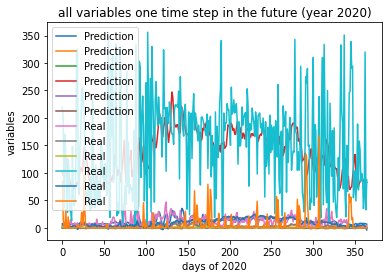

In [ ]:
pyplot.plot(inv_yhat[0][-365:], label = 'Prediction')
pyplot.plot(inv_y[0][-365:], label = 'Real')
pyplot.legend()
pyplot.title("all variables one time step in the future (year 2020)")
pyplot.xlabel('days of 2020') 
pyplot.ylabel('variables') 
pyplot.show()

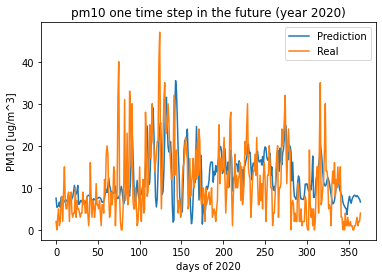

Test RMSE: 7.663


In [ ]:
pred = inv_yhat[0][:,0][-365:]  # first brackets indicate the timestep counting from 5, second the variable, third the days to plot
real = inv_y[0][:,0][-365:]

pyplot.plot(pred, label = 'Prediction') 
pyplot.plot(real, label = 'Real')
pyplot.legend()
pyplot.title("pm10 one time step in the future (year 2020)")
pyplot.xlabel('days of 2020') 
pyplot.ylabel('PM10 [ug/m^3]') 
pyplot.show()

rmse = sqrt(mean_squared_error(pred, real))
print('Test RMSE: %.3f' % rmse)

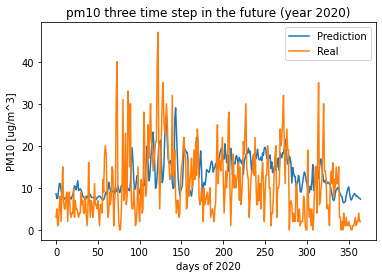

Test RMSE: 8.224


In [ ]:
pred = inv_yhat[2][:,0][-365:]  # first brackets indicate the timestep counting from 5, second the variable, third the days to plot
real = inv_y[2][:,0][-365:]

pyplot.plot(pred, label = 'Prediction') 
pyplot.plot(real, label = 'Real')
pyplot.legend()
pyplot.title("pm10 three time step in the future (year 2020)")
pyplot.xlabel('days of 2020') 
pyplot.ylabel('PM10 [ug/m^3]') 
pyplot.show()

rmse = sqrt(mean_squared_error(pred, real))
print('Test RMSE: %.3f' % rmse)

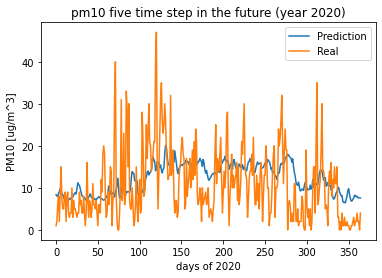

Test RMSE: 7.917


In [ ]:
pred = inv_yhat[4][:,0][-365:]  # first brackets indicate the timestep counting from 5, second the variable, third the days to plot
real = inv_y[4][:,0][-365:]

pyplot.plot(pred, label = 'Prediction') 
pyplot.plot(real, label = 'Real')
pyplot.legend()
pyplot.title("pm10 five time step in the future (year 2020)")
pyplot.xlabel('days of 2020') 
pyplot.ylabel('PM10 [ug/m^3]') 
pyplot.show()


rmse = sqrt(mean_squared_error(pred, real))
print('Test RMSE: %.3f' % rmse)

# LIME

In [ ]:
!pip install lime

In [ ]:
from lime import lime_tabular

In [ ]:
test_X.shape

In [ ]:
explainer = lime_tabular.RecurrentTabularExplainer(test_X, feature_names=["PM10","Ammonia","Wind_speed","Wind_direction","Temperature","Rainfall"], mode='regression')

In [ ]:
exp = explainer.explain_instance(test_X[50], model.predict, num_features=6,labels=(1,))
exp.show_in_notebook()

In [ ]:
exp = explainer.explain_instance(test_X[49], model.predict, num_features=6,labels=(1,))
exp.show_in_notebook()

In [ ]:
exp = explainer.explain_instance(test_X[75], model.predict, num_features=6,labels=(1,))
exp.show_in_notebook()

In [ ]:
test_X[1]

In [ ]:
exp.as_list()